# Trabalho 1 - Reconhecimento de Padrões
Aluno: Luis Felipe Carneiro de Souza

Matrícula: 535049

> Os códigos deste trabalho foram desenvolvido com bases no material em MATLAB/OCTAVE disponibilizado pelo professor

importação de bibliotecas utilizadas

In [1]:
import pandas as pd
import numpy as np
import time
from scipy.spatial.distance import minkowski
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

Lendo o conjunto de dados como um DataFrame

In [2]:
data = "https://raw.githubusercontent.com/LuisFelipeCSouza/reconhecimento-de-padroes/refs/heads/main/trabalho-1/vertebral%2Bcolumn/column_3C.dat"

conjunto = pd.read_csv(data, header=None, sep='\s+')
#print(conjunto.info)
conjunto = conjunto.sample(frac=1)
#conjunto = conjunto.iloc[:30, :] # Pegando os primeiros 60 elementos para os códigos executarem mais rápido
conjunto.head()

,0,1,2,3,4,5,6
241,51.53,13.52,35.00,38.01,126.72,13.93,NO
140,69.56,15.40,74.44,54.16,105.07,29.70,SL
144,60.04,14.31,58.04,45.73,105.13,30.41,SL
68,72.08,18.95,51.00,53.13,114.21,1.01,SL
31,46.39,11.08,32.14,35.31,98.77,6.39,DH


Separando o conjunto de dados entre variáveis de entrada e variáveis resposta

In [3]:
x = conjunto.iloc[:, 0:-1]
y = conjunto.iloc[:, -1]

#x_n = normalize(x, norm='l2', axis=1)
#x = pd.DataFrame(x_n, index=x.index, columns=x.columns)

Dicionário de proporção de separação entre conjunto de treino e teste

In [4]:
sep = {'20/80': {'train': 0.2, 'test': 0.8},
       '30/70': {'train': 0.3, 'test': 0.7},
       '50/50': {'train': 0.5, 'test': 0.5},
       '70/30': {'train': 0.7, 'test': 0.3},
       '80/20': {'train': 0.8, 'test': 0.2}}

In [ ]:
def calcular_estatisticas(lista_acuracias):
    """Calcula estatísticas descritivas de umas lista de acurácias"""
    return {
        'media': np.nanmean(lista_acuracias),
        'desvio': np.nanstd(lista_acuracias),
        'mediana': np.nanmedian(lista_acuracias),
        'minimo': np.nanmin(lista_acuracias),
        'maximo': np.nanmax(lista_acuracias),
    }

from sklearn.metrics import confusion_matrix
import numpy as np

def compilar_resultados(historico_acc, stats_classes, tempo_decorrido, melhor_acc, pior_acc, melhor_dados, pior_dados, classes):
    """
    Consolida os dados brutos do experimento em um dicionário de resultados padronizado.
    """
    
    # Gera as matrizes de confusão aqui dentro para limpar o loop principal
    matriz_melhor = confusion_matrix(
        y_true=melhor_dados['y_true'], 
        y_pred=melhor_dados['y_pred'], 
        labels=classes
    )

    matriz_pior = confusion_matrix(
        y_true=pior_dados['y_true'], 
        y_pred=pior_dados['y_pred'], 
        labels=classes
    )

    return {
        'media': np.mean(historico_acc),
        'desvio': np.std(historico_acc),
        'minimo': np.min(historico_acc),
        'maximo': np.max(historico_acc),
        'stats_por_classe': stats_classes,
        'tempo': tempo_decorrido,
        'melhor_rodada_acc': melhor_acc,
        'pior_rodada_acc': pior_acc,
        'matriz_confusao_melhor': matriz_melhor,
        'matriz_confusao_pior': matriz_pior,
        'classes': classes
    }

### Classificador Vizinho Mais Próximo (distância de Minkowski de ordens m ∈ {0,5; 2/3; 1; 3/2; 2; 5/2})

**Sobre a implementação:**

Loops aninhados que iteram sobre a separação entre conjunto de treino e teste, e variação do parâmetro da distância de Minkowski

In [ ]:
resultados_knn = {} # dicionário para armazenar os resultados
C = np.sort(conjunto.iloc[:, -1].unique()) # classes presentes no conjunto de dados

total_tqdm = len(sep.keys()) * len([0.5, 2/3, 1, 3/2, 2, 5/2]) * len(range(100))
with tqdm.tqdm(total=total_tqdm, desc='KNN progress') as pbar:

    for s in sep.keys(): # diferentes proporções de separação treino/teste
        resultados_knn[s] = {}
        N_trn = round(sep[s]['train'] * len(conjunto)) # número de amostras do conjunto de treino

        for m in [0.5, 2/3, 1, 3/2, 2, 5/2]: # diferentes ordens da distância de Minkowski

            acc_por_classe_lists = {classe: [] for classe in C}
            Pacerto = [] # lista que armazena a porcentagem de acertos em cada rodada
            inicio = time.perf_counter()

            # variaveis para rastrear a melhor e pior rodada
            melhor_acc = -1.0
            pior_acc = 2.0
            melhor_rodada_dados = {'y_true': [], 'y_pred': []}
            pior_rodada_dados = {'y_true': [], 'y_pred': []}

            for rep in range(100): # 100 rodadas de treino

                pbar.update(1)    

                x = x.sample(frac=1) # embaralha as amostras
                y = y.loc[x.index] # embaralha as classes

                x_trn, y_trn = x.iloc[:N_trn, :], y.iloc[:N_trn] # conjunto de treino
                x_tst, y_tst = x.iloc[N_trn:, :], y.iloc[N_trn:] # conjunto de teste

                class_hits = {classe: 0 for classe in C}
                class_totals = {classe: 0 for classe in C}

                # lista para armazenar previsões desta rodada específica
                y_true_rodada = []
                y_pred_rodada = []

                acerto = 0 # contador de acertos
                for i in range(len(x_tst)):
                    x_new = np.array(x_tst.iloc[i, :]) # nova amostra a ser classificada
                    y_true = y_tst.iloc[i] # classe da nova amostra

                    dist_array = []
                    for j in range(len(x_trn)):
                        dist_array.append(minkowski(x_new, np.array(x_trn.iloc[j, :]), p=m)) # distância de Minkowski de ordem m
                    
                    j_min = np.argmin(dist_array) # índice do menor valor de distância
                    y_pred = y_trn.iloc[j_min]

                    # armazena os resultados da amostra
                    y_true_rodada.append(y_true)
                    y_pred_rodada.append(y_pred)

                    class_totals[y_true] += 1
                    if y_pred == y_true: # verifica se a classificação foi correta
                        acerto += 1
                        class_hits[y_true] += 1
            
                acc_rodada_atual = acerto / len(x_tst)
                Pacerto.append(acerto / len(x_tst)) # calcula a porcentagem de acertos

                if acc_rodada_atual > melhor_acc:
                    melhor_acc = acc_rodada_atual
                    melhor_rodada_dados['y_true'] = y_true_rodada
                    melhor_rodada_dados['y_pred'] = y_pred_rodada
                if acc_rodada_atual < pior_acc:
                    pior_acc = acc_rodada_atual
                    pior_rodada_dados['y_true'] = y_true_rodada
                    pior_rodada_dados['y_pred'] = y_pred_rodada

                for classe in C:
                    total = class_totals[classe]
                    hits = class_hits[classe]

                    if total > 0:
                        acc_da_classe_nesta_rodada = hits / total
                    else:
                        acc_da_classe_nesta_rodada = np.nan

                    acc_por_classe_lists[classe].append(acc_da_classe_nesta_rodada)


            fim = time.perf_counter()

            stats_por_classe = {}
            for classe, lista_de_acuracias in acc_por_classe_lists.items():
                stats_por_classe[classe]= calcular_estatisticas(lista_de_acuracias)

            # matriz da melhor rodada
            matriz_melhor = confusion_matrix(y_true=melhor_rodada_dados['y_true'], y_pred=melhor_rodada_dados['y_pred'], labels=C)

            # matriz da pior rodada
            matriz_pior = confusion_matrix(y_true=pior_rodada_dados['y_true'], y_pred=pior_rodada_dados['y_pred'], labels=C)

            resultados_knn[s][m] = compilar_resultados(historico_acc=Pacerto, stats_classes=stats_por_classe, tempo_decorrido=fim - inicio, melhor_acc=melhor_acc, pior_acc=pior_acc, melhor_dados=melhor_rodada_dados, pior_dados=pior_rodada_dados,classes=C)

KNN progress:   0%|          | 10/3000 [00:05<25:14,  1.97it/s]


KeyboardInterrupt: 

### Classificador Distância Mínima ao Centróide

In [ ]:
resultados_centroide = {}
C = np.sort(conjunto.iloc[:, -1].unique()) # classes presentes no conjunto de dados

total_tqdm = len(sep.keys()) * len(range(100))

with tqdm.tqdm(total=total_tqdm, desc='MDC progress') as pbar:

    for s in sep.keys():

        N_trn = round(sep[s]['train'] * len(conjunto)) # número de amostras do conjunto de treino

        acc_por_classe_lists = {classe: [] for classe in C}
        Pacerto = [] # lista que armazena a porcentagem de acertos em cada rodada
        inicio = time.perf_counter()

        melhor_acc = -1.0
        pior_acc = 2.0
        melhor_rodada_dados = {'y_true': [], 'y_pred': []}
        pior_rodada_dados = {'y_true': [], 'y_pred': []}

        for rep in range(100): # 100 rodadas de treino
            #print(f'Rodada de número {rep + 1}')
            pbar.update(1)

            x = x.sample(frac=1)
            y = y.loc[x.index]
            
            x_trn, y_trn = x.iloc[:N_trn, :], y.iloc[:N_trn] # conjunto de treino
            x_tst, y_tst = x.iloc[N_trn:, :], y.iloc[N_trn:] # conjunto de teste

            class_hits = {classe: 0 for classe in C}
            class_totals = {classe: 0  for classe in C}

            y_true_rodada = []
            y_pred_rodada = []

            centroides = {}
            for classe in C:
                df_classe = x_trn[y_trn == classe]
                centroides[classe] = df_classe.mean()

            acerto = 0 # contador de acertos
            for i in range(len(x_tst)): # loop que itera sobre o conjunto de teste
                x_new = np.array(x_tst.iloc[i, :]) # nova amostra a ser classificada
                y_true = y_tst.iloc[i] # classe da nova amostra

                dist_array = []
                for k in C:
                    #print(x_new, np.array(centroides[k]))
                    dist_array.append(minkowski(x_new, np.array(centroides[k]), p=2)) # distância Euclidiana ao centróide da classe k
                
                k_min = np.argmin(dist_array) # índice do menor valor de distância
                y_pred = C[k_min]

                y_true_rodada.append(y_true)
                y_pred_rodada.append(y_pred)

                class_totals[y_true] += 1
                if y_pred == y_true:
                    acerto += 1
                    class_hits[y_true] += 1
            
            acc_rodada_atual = acerto / len(x_tst)
            Pacerto.append(acerto / len(x_tst))

            if acc_rodada_atual > melhor_acc:
                melhor_acc = acc_rodada_atual
                melhor_rodada_dados['y_true'] = list(y_true_rodada)
                melhor_rodada_dados['y_pred'] = list(y_pred_rodada)

            if acc_rodada_atual < pior_acc:
                pior_acc = acc_rodada_atual
                pior_rodada_dados['y_true'] = list(y_true_rodada)
                pior_rodada_dados['y_pred'] = list(y_pred_rodada)

            for classe in C:
                total = class_totals[classe]
                hits = class_hits[classe]

                if total > 0:
                    acc_da_classe_nesta_rodada = hits / total
                else:
                    acc_da_classe_nesta_rodada = np.nan

                acc_por_classe_lists[classe].append(acc_da_classe_nesta_rodada)

        fim = time.perf_counter()

        stats_por_classe = {}
        for classe, lista_de_acuracias in acc_por_classe_lists.items():
            stats_por_classe[classe]= calcular_estatisticas(lista_de_acuracias)


        # Matriz da melhor rodada
        matriz_melhor = confusion_matrix(
            y_true=melhor_rodada_dados['y_true'],
            y_pred=melhor_rodada_dados['y_pred'],
            labels=C # Usa as classes ordenadas
        )
        
        # Matriz da pior rodada
        matriz_pior = confusion_matrix(
            y_true=pior_rodada_dados['y_true'],
            y_pred=pior_rodada_dados['y_pred'],
            labels=C # Usa as classes ordenadas
        )
        
        resultados_centroide[s] = compilar_resultados(historico_acc=Pacerto, stats_classes=stats_por_classe, tempo_decorrido=fim - inicio, melhor_acc=melhor_acc, pior_acc=pior_acc, melhor_dados=melhor_rodada_dados, pior_dados=pior_rodada_dados,classes=C)
    #resultados_centroide

MDC progress: 100%|██████████| 500/500 [00:05<00:00, 87.99it/s] 


### Classificador Distância Mínima ao Centróide (versão robusta a outliers)

In [ ]:
resultados_centroide_robusto = {}
C = np.sort(conjunto.iloc[:, -1].unique())

total_tqdm = len(sep.keys()) * len(range(100))

with tqdm.tqdm(total=total_tqdm, desc='MDC robust progress') as pbar:

    for s in sep.keys():

        N_trn = round(sep[s]['train'] * len(conjunto)) # número de amostras do conjunto de treino

        acc_por_classe_lists = {classe: [] for classe in C}
        Pacerto = [] # lista que armazena a porcentagem de acertos em cada rodada
        inicio = time.perf_counter()

        melhor_acc = -1.0
        pior_acc = 2.0
        melhor_rodada_dados = {'y_true': [], 'y_pred': []}
        pior_rodada_dados = {'y_true': [], 'y_pred': []}

        for rep in range(100): # 100 rodadas de treino
            #print(f'Rodada de número {rep + 1}')
            pbar.update(1)

            x = x.sample(frac=1)
            y = y.loc[x.index]
            
            x_trn, y_trn = x.iloc[:N_trn, :], y.iloc[:N_trn] # conjunto de treino
            x_tst, y_tst = x.iloc[N_trn:, :], y.iloc[N_trn:] # conjunto de teste

            class_hits = {classe: 0 for classe in C}
            class_totals = {classe: 0  for classe in C}

            y_true_rodada = []
            y_pred_rodada = []

            centroides = {}
            for classe in C:
                df_classe = x_trn[y_trn == classe]
                centroides[classe] = df_classe.median()

            acerto = 0 # contador de acertos
            for i in range(len(x_tst)):
                x_new = np.array(x_tst.iloc[i, :]) # nova amostra a ser classificada
                y_true = y_tst.iloc[i] # classe da nova amostra

                dist_array = []
                for k in C:
                    #print(x_new, np.array(centroides[k]))
                    dist_array.append(minkowski(x_new, np.array(centroides[k]), p=1)) # distância quarteirao ao centróide da classe k
                
                k_min = np.argmin(dist_array) # índice do menor valor de distância
                y_pred = C[k_min]

                y_true_rodada.append(y_true)
                y_pred_rodada.append(y_pred)

                class_totals[y_true] += 1
                if y_pred == y_true:
                    acerto += 1
                    class_hits[y_true] += 1
            
            acc_rodada_atual = acerto / len(x_tst)
            Pacerto.append(acerto / len(x_tst))

            if acc_rodada_atual > melhor_acc:
                melhor_acc = acc_rodada_atual
                melhor_rodada_dados['y_true'] = list(y_true_rodada)
                melhor_rodada_dados['y_pred'] = list(y_pred_rodada)

            if acc_rodada_atual < pior_acc:
                pior_acc = acc_rodada_atual
                pior_rodada_dados['y_true'] = list(y_true_rodada)
                pior_rodada_dados['y_pred'] = list(y_pred_rodada)

            for classe in C:
                total = class_totals[classe]
                hits = class_hits[classe]

                if total > 0:
                    acc_da_classe_nesta_rodada = hits / total
                else:
                    acc_da_classe_nesta_rodada = np.nan

                acc_por_classe_lists[classe].append(acc_da_classe_nesta_rodada)

        fim = time.perf_counter()

        stats_por_classe = {}
        for classe, lista_de_acuracias in acc_por_classe_lists.items():
            stats_por_classe[classe]= calcular_estatisticas(lista_de_acuracias)

        # Matriz da melhor rodada
        matriz_melhor = confusion_matrix(
            y_true=melhor_rodada_dados['y_true'],
            y_pred=melhor_rodada_dados['y_pred'],
            labels=C # Usa as classes ordenadas
        )
        
        # Matriz da pior rodada
        matriz_pior = confusion_matrix(
            y_true=pior_rodada_dados['y_true'],
            y_pred=pior_rodada_dados['y_pred'],
            labels=C # Usa as classes ordenadas
        )
        
        resultados_centroide_robusto[s] = compilar_resultados(historico_acc=Pacerto, stats_classes=stats_por_classe, tempo_decorrido=fim - inicio, melhor_acc=melhor_acc, pior_acc=pior_acc, melhor_dados=melhor_rodada_dados, pior_dados=pior_rodada_dados,classes=C)
    #resultados_centroide_robusto

MDC robust progress: 100%|██████████| 500/500 [00:06<00:00, 77.89it/s] 


### Classificador de Máxima Correlação

In [ ]:
resultados_similaridade = {}
C = np.sort(conjunto.iloc[:, -1].unique())

x = conjunto.iloc[:, 0:-1]
y = conjunto.iloc[:, -1]

x_n = normalize(x, norm='l2', axis=1)
x = pd.DataFrame(x_n, index=x.index, columns=x.columns)

total_tqdm = len(sep.keys()) * len(range(100))

with tqdm.tqdm(total=total_tqdm, desc='MDC progress') as pbar:

    for s in sep.keys():

        N_trn = round(sep[s]['train'] * len(conjunto)) # número de amostras do conjunto de treino

        acc_por_classe_lists = {classe: [] for classe in C}
        Pacerto = [] # lista que armazena a porcentagem de acertos em cada rodada
        inicio = time.perf_counter()

        melhor_acc = -1.0
        pior_acc = 2.0
        melhor_rodada_dados = {'y_true': [], 'y_pred': []}
        pior_rodada_dados = {'y_true': [], 'y_pred': []}

        for rep in range(100): # 100 rodadas de treino
            #print(f'Rodada de número {rep + 1}')
            pbar.update(1)

            x = x.sample(frac=1)
            y = y.loc[x.index]
            
            x_trn, y_trn = x.iloc[:N_trn, :], y.iloc[:N_trn] # conjunto de treino
            x_tst, y_tst = x.iloc[N_trn:, :], y.iloc[N_trn:] # conjunto de teste

            class_hits = {classe: 0 for classe in C}
            class_totals = {classe: 0  for classe in C}

            y_true_rodada = []
            y_pred_rodada = []

            centroides = {}
            for classe in C:
                df_classe = x_trn[y_trn == classe]
                centroides[classe] = df_classe.mean()

            acerto = 0 # contador de acertos
            for i in x_tst.index:
                x_new = np.array(x_tst.loc[i, :]) # nova amostra a ser classificada
                y_true = y_tst.loc[i] # classe da nova amostra

                sim = []
                for k in C:
                    sim.append(np.dot(x_new, np.array(centroides[k]))) # distância Euclidiana ao centróide da classe k
                
                k_min = np.argmax(sim) # índice do menor valor de distância
                y_pred = C[k_min]

                y_true_rodada.append(y_true)
                y_pred_rodada.append(y_pred)

                class_totals[y_true] += 1
                if y_pred == y_true:
                    acerto += 1
                    class_hits[y_true] += 1
            
            acc_rodada_atual = acerto / len(x_tst)
            Pacerto.append(acerto / len(x_tst))

            if acc_rodada_atual > melhor_acc:
                melhor_acc = acc_rodada_atual
                melhor_rodada_dados['y_true'] = list(y_true_rodada)
                melhor_rodada_dados['y_pred'] = list(y_pred_rodada)

            if acc_rodada_atual < pior_acc:
                pior_acc = acc_rodada_atual
                pior_rodada_dados['y_true'] = list(y_true_rodada)
                pior_rodada_dados['y_pred'] = list(y_pred_rodada)

            for classe in C:
                total = class_totals[classe]
                hits = class_hits[classe]

                if total > 0:
                    acc_da_classe_nesta_rodada = hits / total
                else:
                    acc_da_classe_nesta_rodada = np.nan

                acc_por_classe_lists[classe].append(acc_da_classe_nesta_rodada)

        fim = time.perf_counter()

        stats_por_classe = {}
        for classe, lista_de_acuracias in acc_por_classe_lists.items():
            stats_por_classe[classe]= calcular_estatisticas(lista_de_acuracias)


        # Matriz da melhor rodada
        matriz_melhor = confusion_matrix(
            y_true=melhor_rodada_dados['y_true'],
            y_pred=melhor_rodada_dados['y_pred'],
            labels=C # Usa as classes ordenadas
        )
        
        # Matriz da pior rodada
        matriz_pior = confusion_matrix(
            y_true=pior_rodada_dados['y_true'],
            y_pred=pior_rodada_dados['y_pred'],
            labels=C # Usa as classes ordenadas
        )

        resultados_similaridade[s] = compilar_resultados(historico_acc=Pacerto, stats_classes=stats_por_classe, tempo_decorrido=fim - inicio, melhor_acc=melhor_acc, pior_acc=pior_acc, melhor_dados=melhor_rodada_dados, pior_dados=pior_rodada_dados,classes=C)
    resultados_similaridade

MDC progress: 100%|██████████| 500/500 [00:04<00:00, 101.81it/s]


### Resultados

In [10]:
# Suprime avisos do pandas e seaborn que podem poluir a saída
#warnings.filterwarnings('ignore', category=UserWarning)
#warnings.filterwarnings('ignore', category=FutureWarning)

# 1. Consolidação dos Dados em um único DataFrame

# Lista para armazenar todos os resultados globais
dados_grafico = []
# Lista para armazenar os resultados por classe
dados_por_classe = []

# Pega as classes (ex: 'NO', 'SL', 'DH') e a ordem da separação
try:
    # Tenta pegar as classes do primeiro resultado do k-NN
    C = list(resultados_knn['20/80'][0.5]['stats_por_classe'].keys())
    ordem_separacao = list(sep.keys()) # ['20/80', '30/70', ...]
except (NameError, KeyError):
    print("AVISO: Dicionários de resultados (ex: 'resultados_knn') não encontrados.")
    print("Executando com dados de exemplo. Rode as células dos classificadores primeiro.")
    # Define valores padrão para evitar que o resto do código quebre
    C = ['DH', 'NO', 'SL'] 
    ordem_separacao = ['20/80', '30/70', '50/50', '70/30', '80/20']
    # Cria dicionários vazios para não dar erro
    resultados_knn = {}
    resultados_centroide = {}
    resultados_centroide_robusto = {}
    resultados_similaridade = {}


# --- Processa os resultados do k-NN ---
for separacao, resultados_m in resultados_knn.items():
    for m, metricas in resultados_m.items():
        rotulo_m = f'{m:.2f}'
        # Adiciona dados globais
        dados_grafico.append({
            'classificador': 'k-NN',
            'separacao': separacao,
            'proporcao_treino': int(separacao.split('/')[0]),
            'parametro_m': rotulo_m,
            'rotulo_curto': f'k-NN (m={rotulo_m})',
            'media': metricas.get('media'),
            'desvio': metricas.get('desvio'),
            'tempo': metricas.get('tempo'),
            'matriz_confusao_melhor': metricas.get('matriz_confusao_melhor'),
            'matriz_confusao_pior': metricas.get('matriz_confusao_pior'),
            'classes_matriz': metricas.get('classes_matriz')
        })
        # Adiciona dados por classe
        for classe, class_stats in metricas.get('stats_por_classe', {}).items():
            dados_por_classe.append({
                'classificador': 'k-NN',
                'separacao': separacao,
                'proporcao_treino': int(separacao.split('/')[0]),
                'parametro_m': rotulo_m,
                'rotulo_curto': f'k-NN (m={rotulo_m})',
                'classe': classe,
                'media_classe': class_stats.get('media'),
                'desvio_classe': class_stats.get('desvio')
            })

# --- Função auxiliar para os outros classificadores ---
def processar_classificador(nome_classificador, resultados_dict, lista_global, lista_classe):
    for separacao, metricas in resultados_dict.items():
        # Adiciona dados globais
        lista_global.append({
            'classificador': nome_classificador,
            'separacao': separacao,
            'proporcao_treino': int(separacao.split('/')[0]),
            'parametro_m': 'N/A',
            'rotulo_curto': nome_classificador,
            'media': metricas.get('media'),
            'desvio': metricas.get('desvio'),
            'tempo': metricas.get('tempo'),
            'matriz_confusao_melhor': metricas.get('matriz_confusao_melhor'),
            'matriz_confusao_pior': metricas.get('matriz_confusao_pior'),
            'classes_matriz': metricas.get('classes_matriz')
        })
        # Adiciona dados por classe
        for classe, class_stats in metricas.get('stats_por_classe', {}).items():
            lista_classe.append({
                'classificador': nome_classificador,
                'separacao': separacao,
                'proporcao_treino': int(separacao.split('/')[0]),
                'parametro_m': 'N/A',
                'rotulo_curto': nome_classificador,
                'classe': classe,
                'media_classe': class_stats.get('media'),
                'desvio_classe': class_stats.get('desvio')
            })

# Processa os outros
processar_classificador('Centróide', resultados_centroide, dados_grafico, dados_por_classe)
processar_classificador('Centróide Robusto', resultados_centroide_robusto, dados_grafico, dados_por_classe)
processar_classificador('Máx. Similaridade', resultados_similaridade, dados_grafico, dados_por_classe)

# --- Cria os DataFrames Finais e Ordena ---
df_final = pd.DataFrame(dados_grafico)
df_classes = pd.DataFrame(dados_por_classe)

# Define a ordem correta dos classificadores e rótulos
ordem_classificador = ['k-NN', 'Centróide', 'Centróide Robusto', 'Máx. Similaridade']
# Gera a ordem dos rótulos curtos
ordem_rotulos = []
for classif in ordem_classificador:
    if classif == 'k-NN':
        for m in [0.5, 2/3, 1, 3/2, 2, 5/2]: #
            ordem_rotulos.append(f'k-NN (m={m:.2f})')
    else:
        ordem_rotulos.append(classif)

# Aplica a ordem categórica aos DataFrames
if not df_final.empty:
    df_final['rotulo_curto'] = pd.Categorical(df_final['rotulo_curto'], categories=ordem_rotulos, ordered=True)
    df_final['separacao'] = pd.Categorical(df_final['separacao'], categories=ordem_separacao, ordered=True)
    df_final_ordenado = df_final.sort_values(['separacao', 'rotulo_curto'])
else:
    df_final_ordenado = pd.DataFrame(columns=df_final.columns) # Cria DF vazio se não houver dados

if not df_classes.empty:
    df_classes['rotulo_curto'] = pd.Categorical(df_classes['rotulo_curto'], categories=ordem_rotulos, ordered=True)
    df_classes['separacao'] = pd.Categorical(df_classes['separacao'], categories=ordem_separacao, ordered=True)
    df_classes_ordenado = df_classes.sort_values(['separacao', 'rotulo_curto', 'classe'])
    C_ordenado = sorted(list(df_classes_ordenado['classe'].unique())) # Ordem das classes, ex: ['DH', 'NO', 'SL']
else:
    df_classes_ordenado = pd.DataFrame(columns=df_classes.columns)
    C_ordenado = C # Usa o C definido no 'try'
    
print("DataFrames prontos para plotagem.")
#print(df_final_ordenado.head())
#print(df_classes_ordenado.head())

DataFrames prontos para plotagem.


--- Gerando gráficos para a separação 20/80 ---


C:\Users\GREI-Luis-Felipe\AppData\Local\Temp\ipykernel_8708\3689277163.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_g_s, x='rotulo_curto', y='media', order=rotulos_x, ax=ax1, palette='viridis')
C:\Users\GREI-Luis-Felipe\AppData\Local\Temp\ipykernel_8708\3689277163.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(rotulos_x, rotation=90)
C:\Users\GREI-Luis-Felipe\AppData\Local\Temp\ipykernel_8708\3689277163.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_g_s, x='rotulo_curto', y='tempo', order=rotulos_x, ax=ax2, palette='plasma')
C:\Users\GREI-Luis-Felipe\A

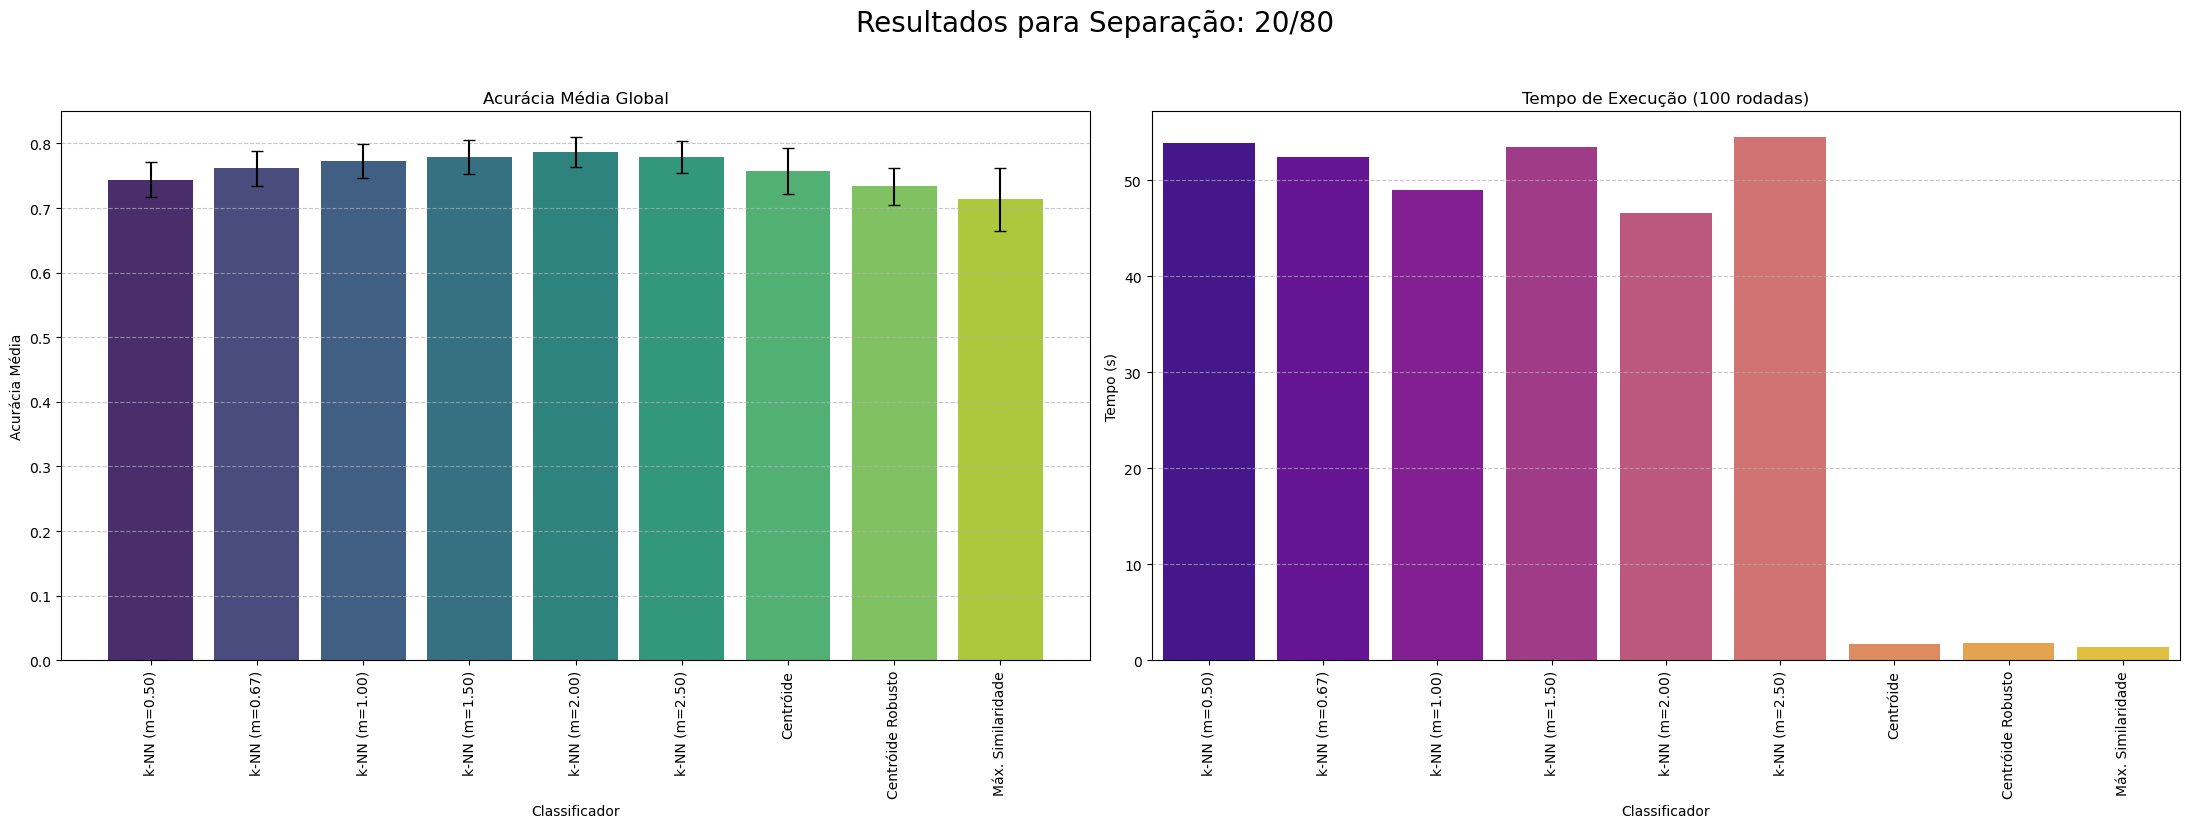

C:\Users\GREI-Luis-Felipe\AppData\Local\Temp\ipykernel_8708\3689277163.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
C:\Users\GREI-Luis-Felipe\AppData\Local\Temp\ipykernel_8708\3689277163.py:51: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(
C:\Users\GREI-Luis-Felipe\AppData\Local\Temp\ipykernel_8708\3689277163.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['rotulo_curto'] = pd.Categorical(df_subset['rotulo_curto'], categories=rotulos_x, ordered=True)
C:\Users\GREI-Luis-Felipe\AppData\Local\Temp\ipykernel_8

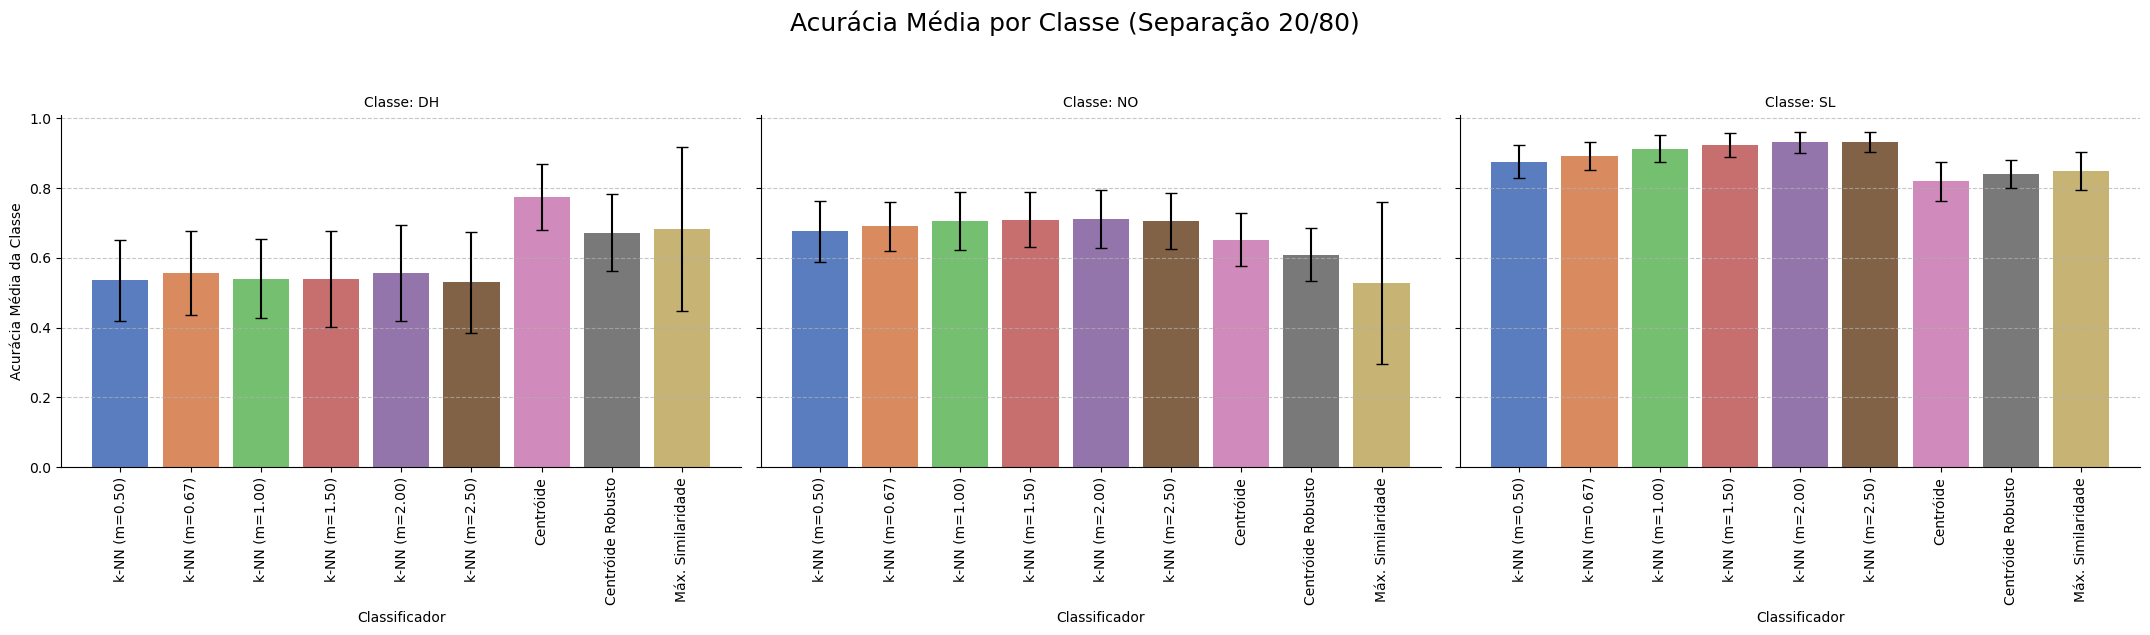

--- Gerando gráficos para a separação 30/70 ---


C:\Users\GREI-Luis-Felipe\AppData\Local\Temp\ipykernel_8708\3689277163.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_g_s, x='rotulo_curto', y='media', order=rotulos_x, ax=ax1, palette='viridis')
C:\Users\GREI-Luis-Felipe\AppData\Local\Temp\ipykernel_8708\3689277163.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(rotulos_x, rotation=90)
C:\Users\GREI-Luis-Felipe\AppData\Local\Temp\ipykernel_8708\3689277163.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_g_s, x='rotulo_curto', y='tempo', order=rotulos_x, ax=ax2, palette='plasma')
C:\Users\GREI-Luis-Felipe\A

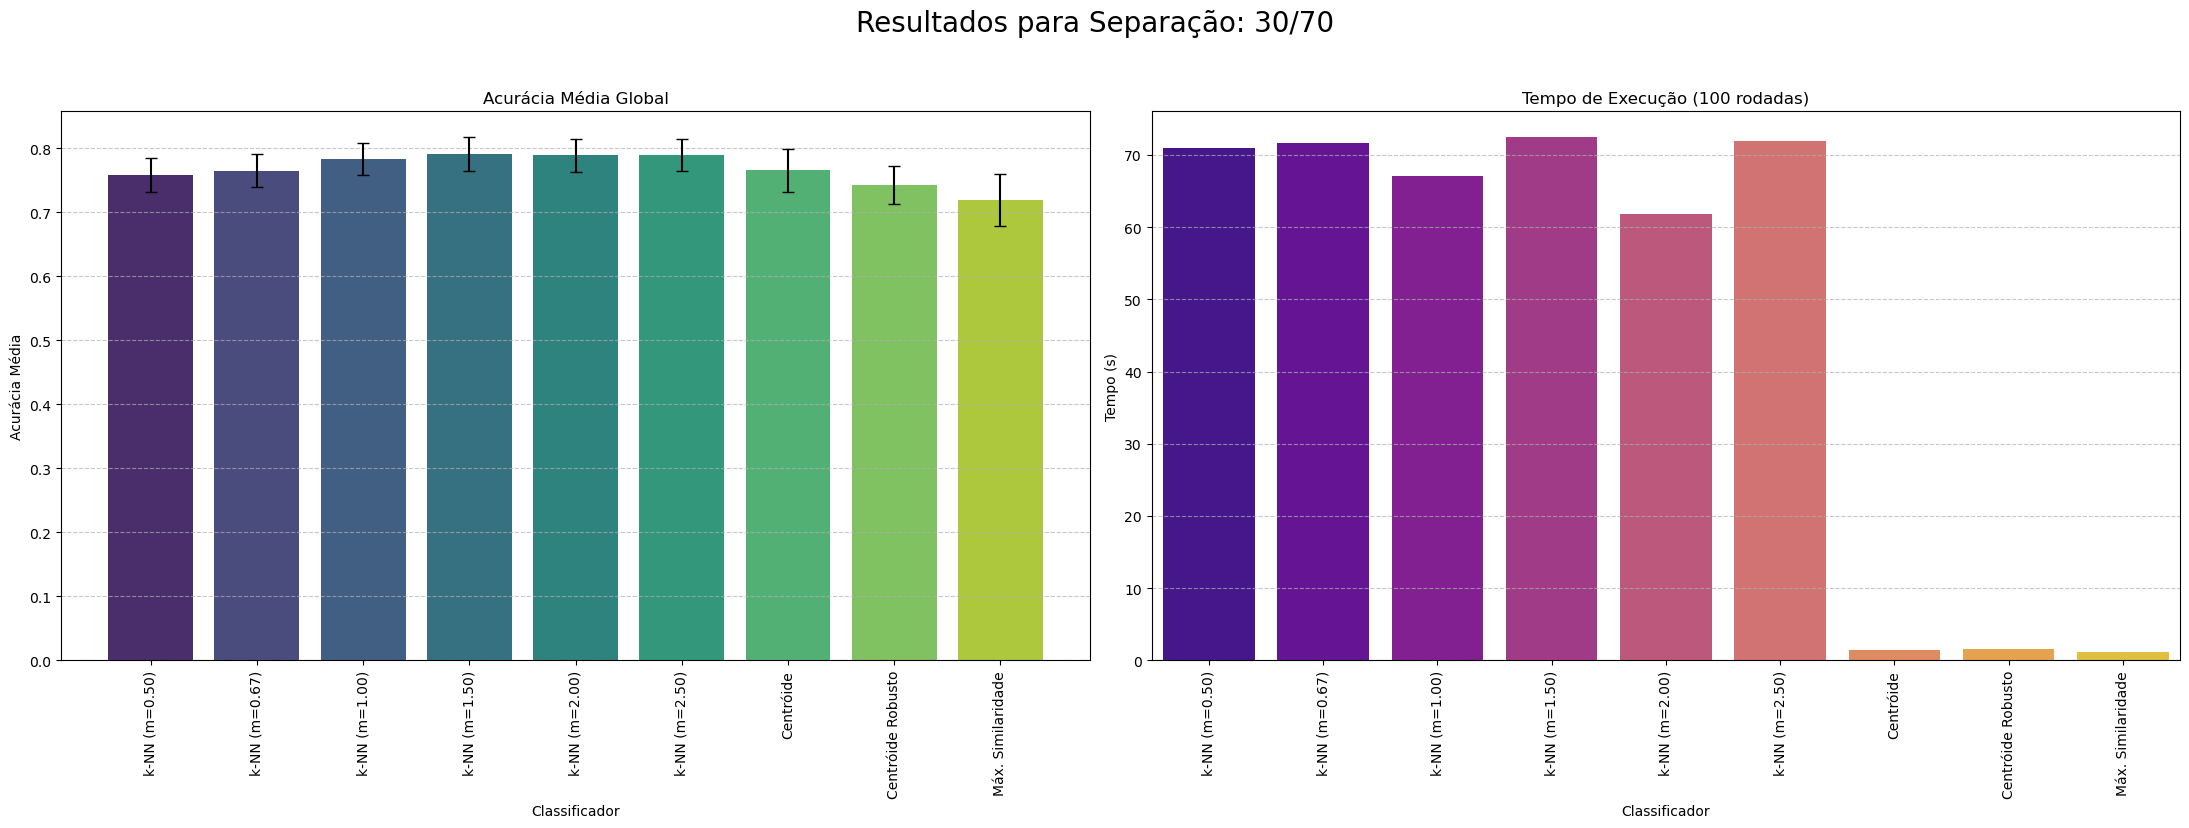

C:\Users\GREI-Luis-Felipe\AppData\Local\Temp\ipykernel_8708\3689277163.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
C:\Users\GREI-Luis-Felipe\AppData\Local\Temp\ipykernel_8708\3689277163.py:51: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(
C:\Users\GREI-Luis-Felipe\AppData\Local\Temp\ipykernel_8708\3689277163.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['rotulo_curto'] = pd.Categorical(df_subset['rotulo_curto'], categories=rotulos_x, ordered=True)
C:\Users\GREI-Luis-Felipe\AppData\Local\Temp\ipykernel_8

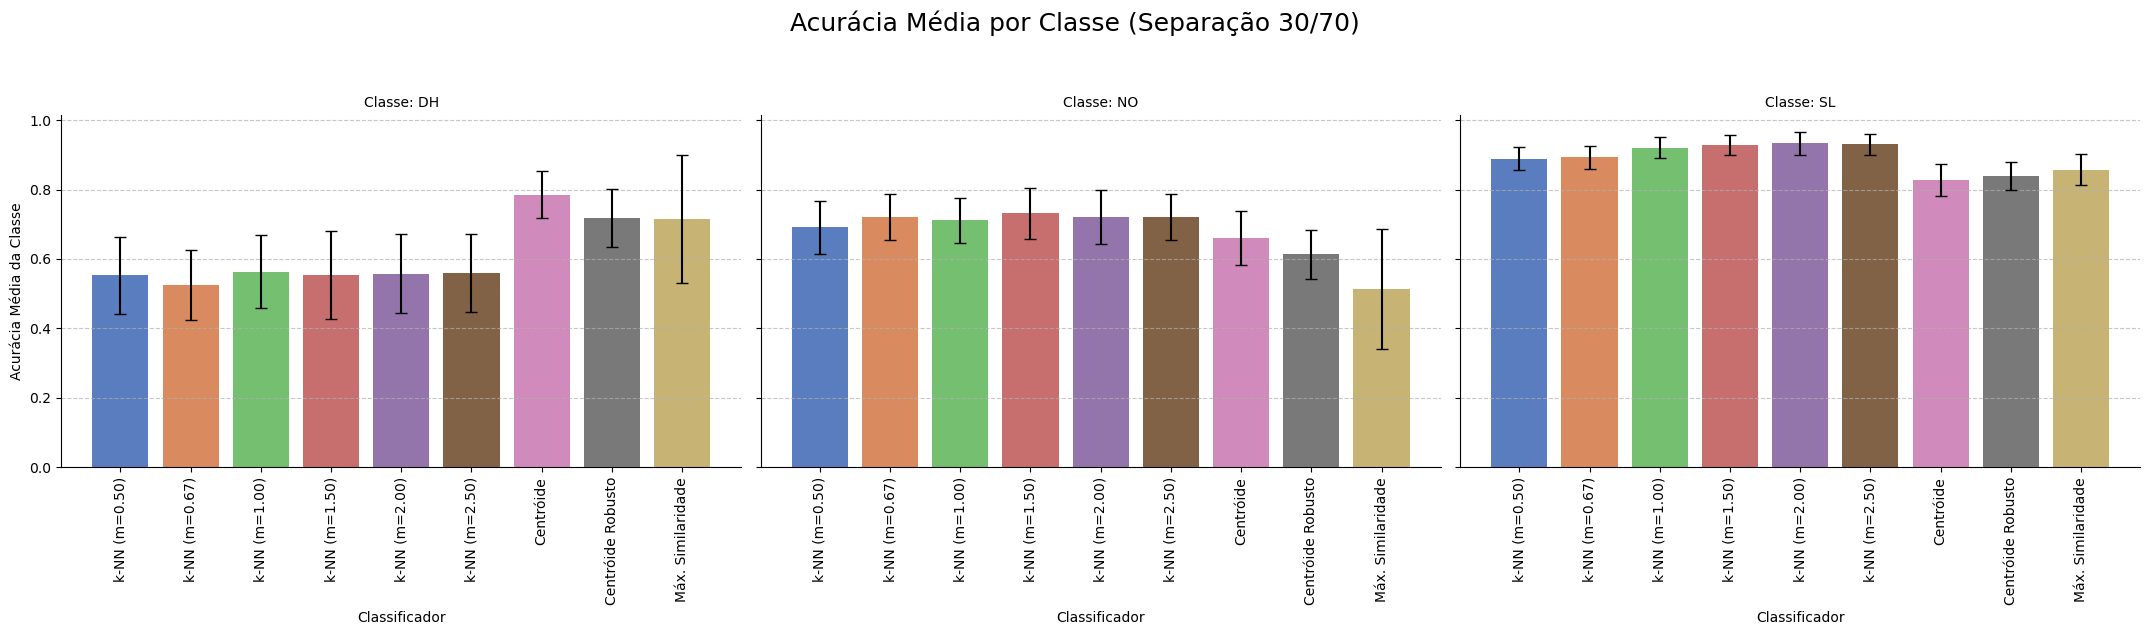

--- Gerando gráficos para a separação 50/50 ---


C:\Users\GREI-Luis-Felipe\AppData\Local\Temp\ipykernel_8708\3689277163.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_g_s, x='rotulo_curto', y='media', order=rotulos_x, ax=ax1, palette='viridis')
C:\Users\GREI-Luis-Felipe\AppData\Local\Temp\ipykernel_8708\3689277163.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(rotulos_x, rotation=90)
C:\Users\GREI-Luis-Felipe\AppData\Local\Temp\ipykernel_8708\3689277163.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_g_s, x='rotulo_curto', y='tempo', order=rotulos_x, ax=ax2, palette='plasma')
C:\Users\GREI-Luis-Felipe\A

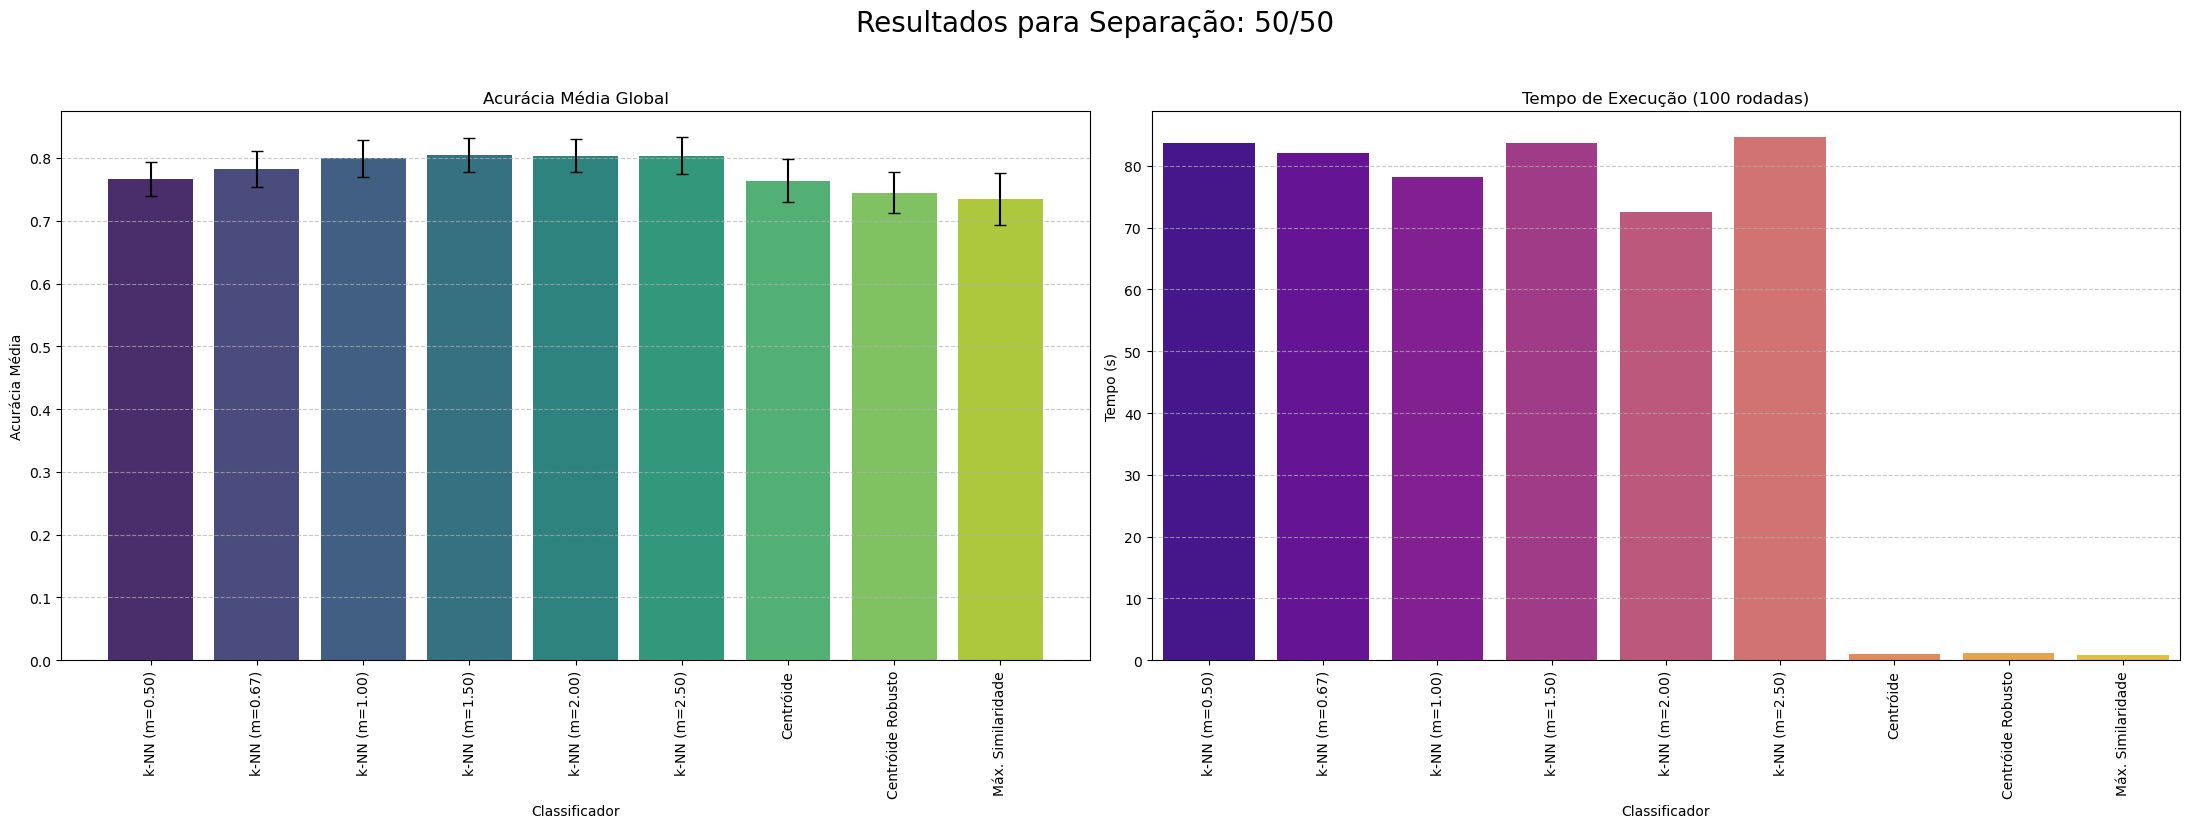

C:\Users\GREI-Luis-Felipe\AppData\Local\Temp\ipykernel_8708\3689277163.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
C:\Users\GREI-Luis-Felipe\AppData\Local\Temp\ipykernel_8708\3689277163.py:51: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(
C:\Users\GREI-Luis-Felipe\AppData\Local\Temp\ipykernel_8708\3689277163.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['rotulo_curto'] = pd.Categorical(df_subset['rotulo_curto'], categories=rotulos_x, ordered=True)
C:\Users\GREI-Luis-Felipe\AppData\Local\Temp\ipykernel_8

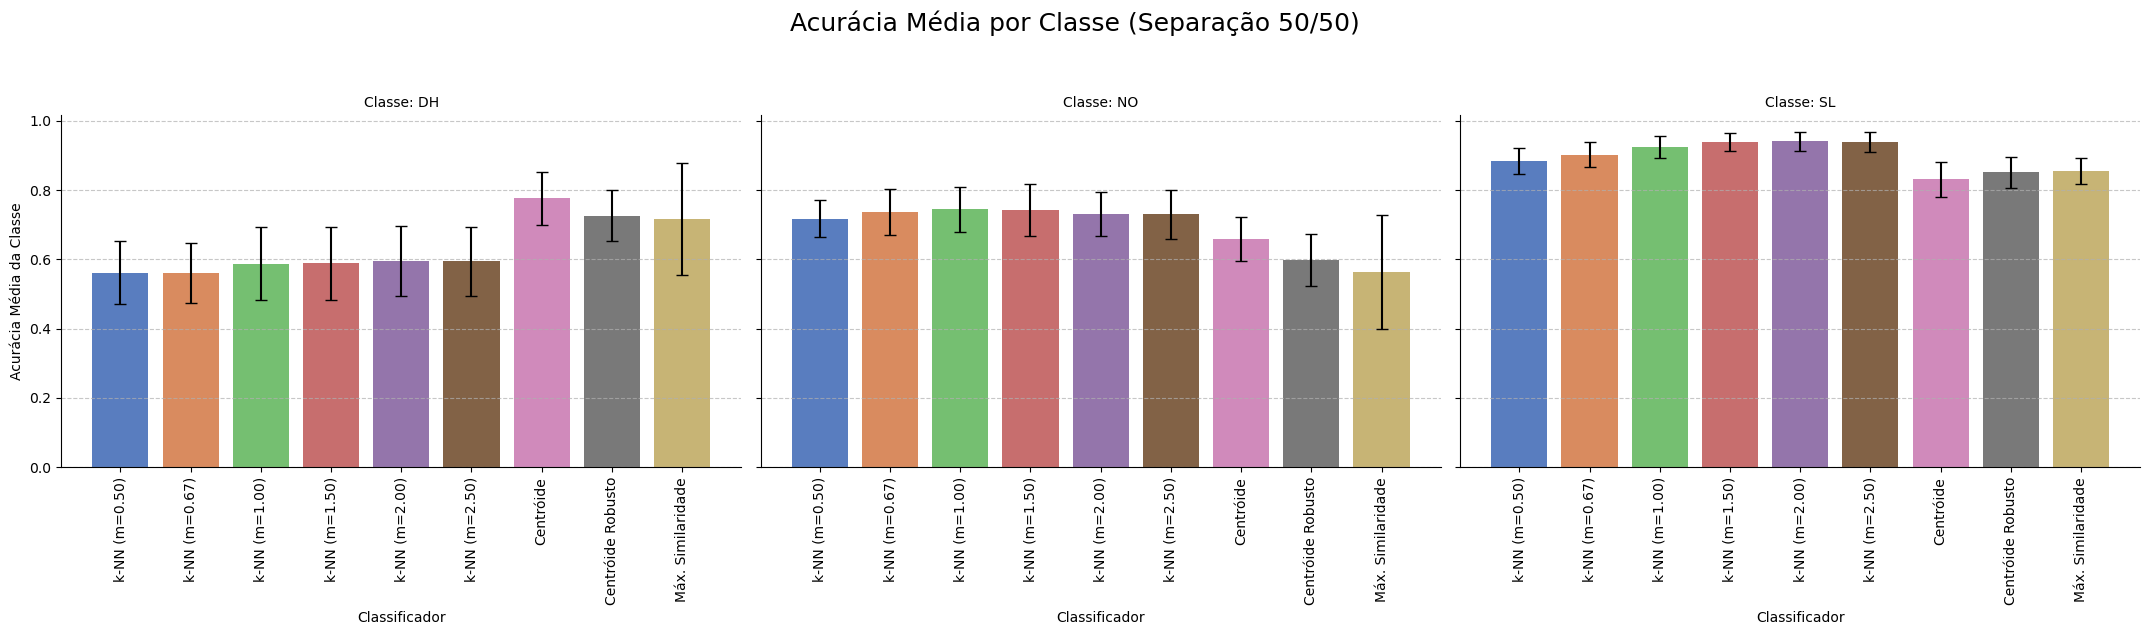

--- Gerando gráficos para a separação 70/30 ---


C:\Users\GREI-Luis-Felipe\AppData\Local\Temp\ipykernel_8708\3689277163.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_g_s, x='rotulo_curto', y='media', order=rotulos_x, ax=ax1, palette='viridis')
C:\Users\GREI-Luis-Felipe\AppData\Local\Temp\ipykernel_8708\3689277163.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(rotulos_x, rotation=90)
C:\Users\GREI-Luis-Felipe\AppData\Local\Temp\ipykernel_8708\3689277163.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_g_s, x='rotulo_curto', y='tempo', order=rotulos_x, ax=ax2, palette='plasma')
C:\Users\GREI-Luis-Felipe\A

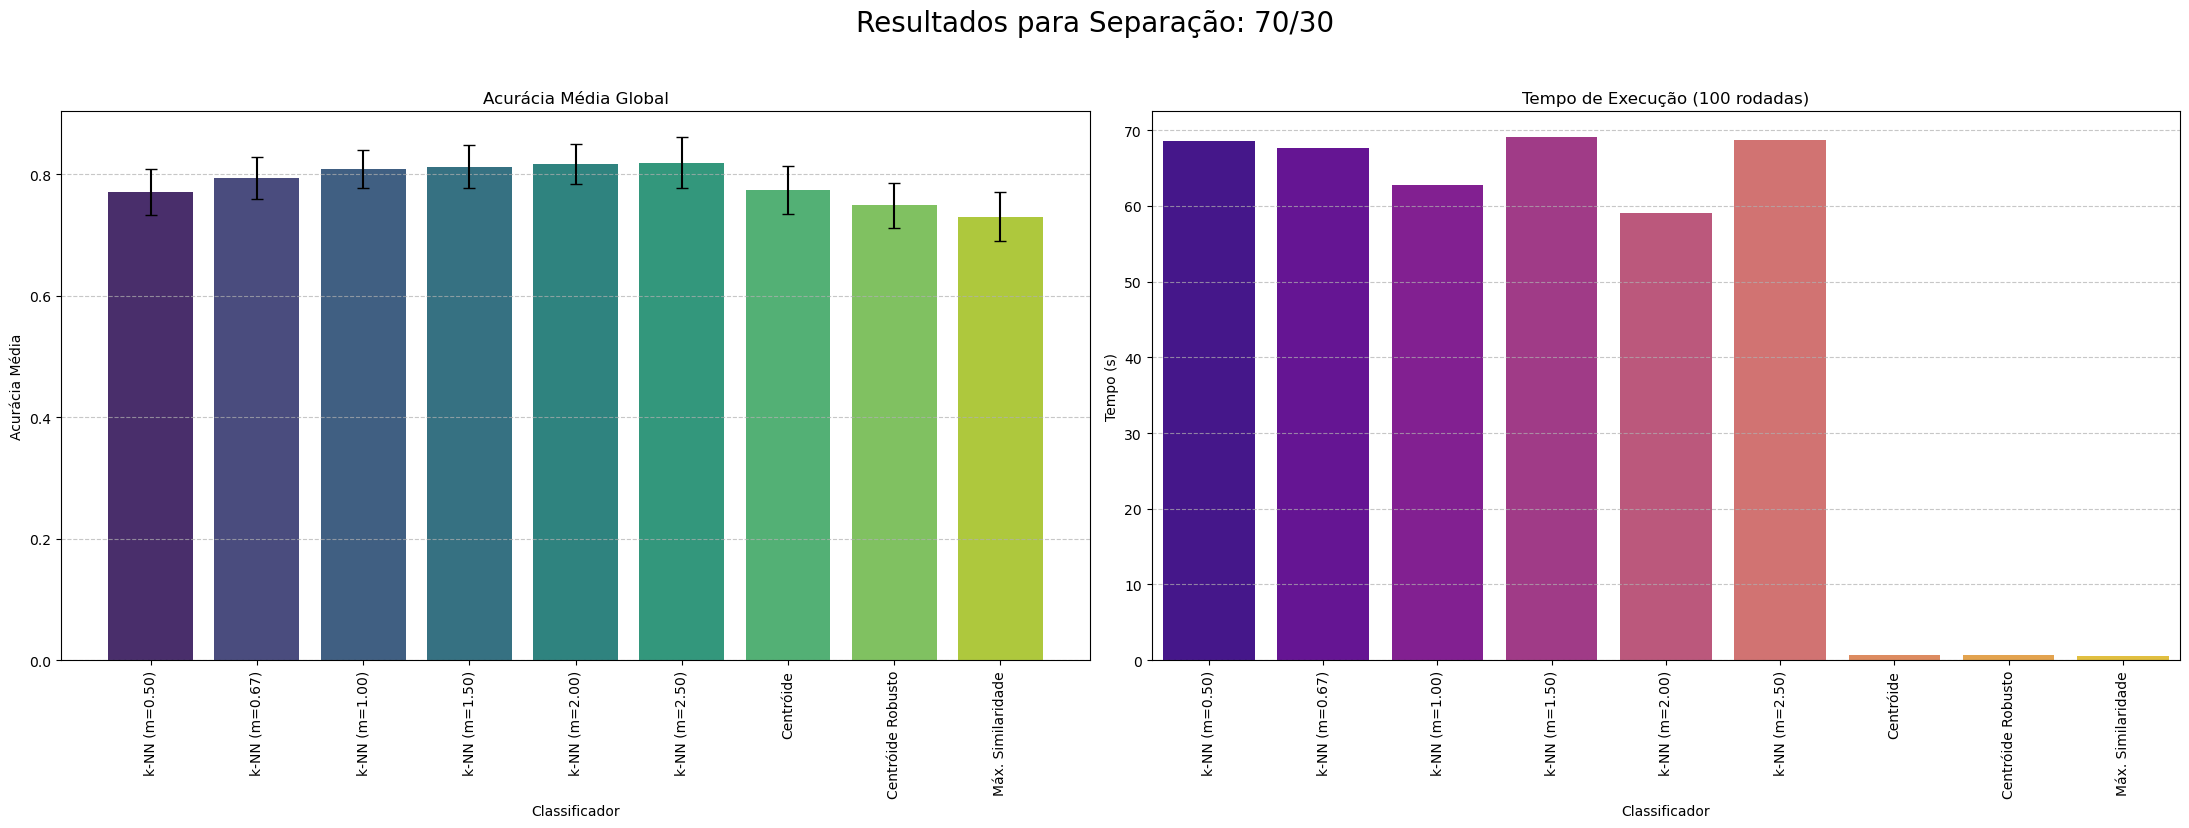

C:\Users\GREI-Luis-Felipe\AppData\Local\Temp\ipykernel_8708\3689277163.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
C:\Users\GREI-Luis-Felipe\AppData\Local\Temp\ipykernel_8708\3689277163.py:51: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(
C:\Users\GREI-Luis-Felipe\AppData\Local\Temp\ipykernel_8708\3689277163.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['rotulo_curto'] = pd.Categorical(df_subset['rotulo_curto'], categories=rotulos_x, ordered=True)
C:\Users\GREI-Luis-Felipe\AppData\Local\Temp\ipykernel_8

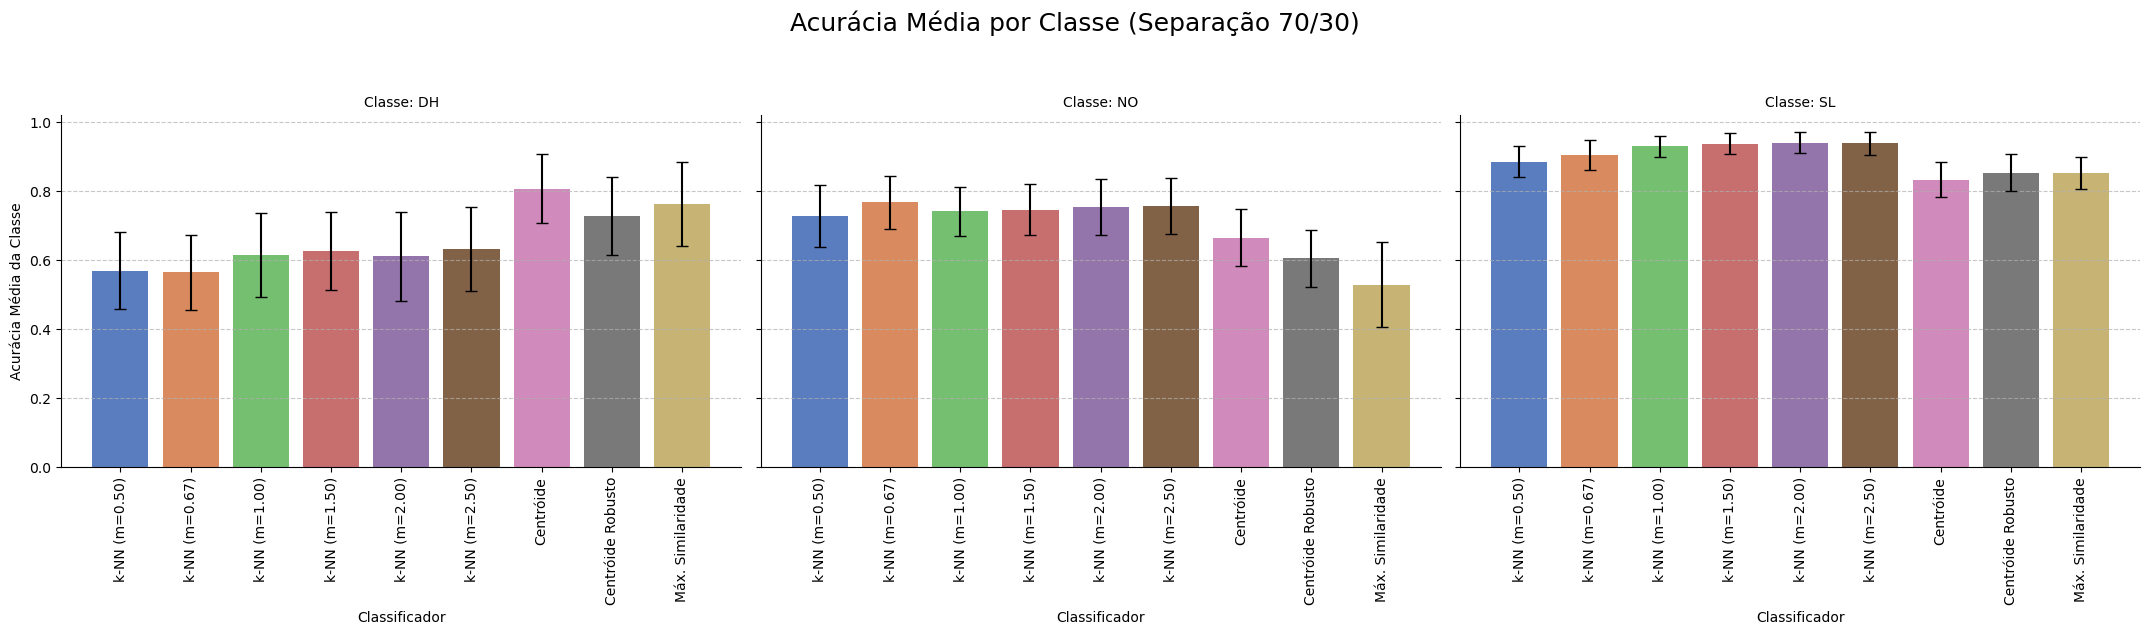

--- Gerando gráficos para a separação 80/20 ---


C:\Users\GREI-Luis-Felipe\AppData\Local\Temp\ipykernel_8708\3689277163.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_g_s, x='rotulo_curto', y='media', order=rotulos_x, ax=ax1, palette='viridis')
C:\Users\GREI-Luis-Felipe\AppData\Local\Temp\ipykernel_8708\3689277163.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(rotulos_x, rotation=90)
C:\Users\GREI-Luis-Felipe\AppData\Local\Temp\ipykernel_8708\3689277163.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_g_s, x='rotulo_curto', y='tempo', order=rotulos_x, ax=ax2, palette='plasma')
C:\Users\GREI-Luis-Felipe\A

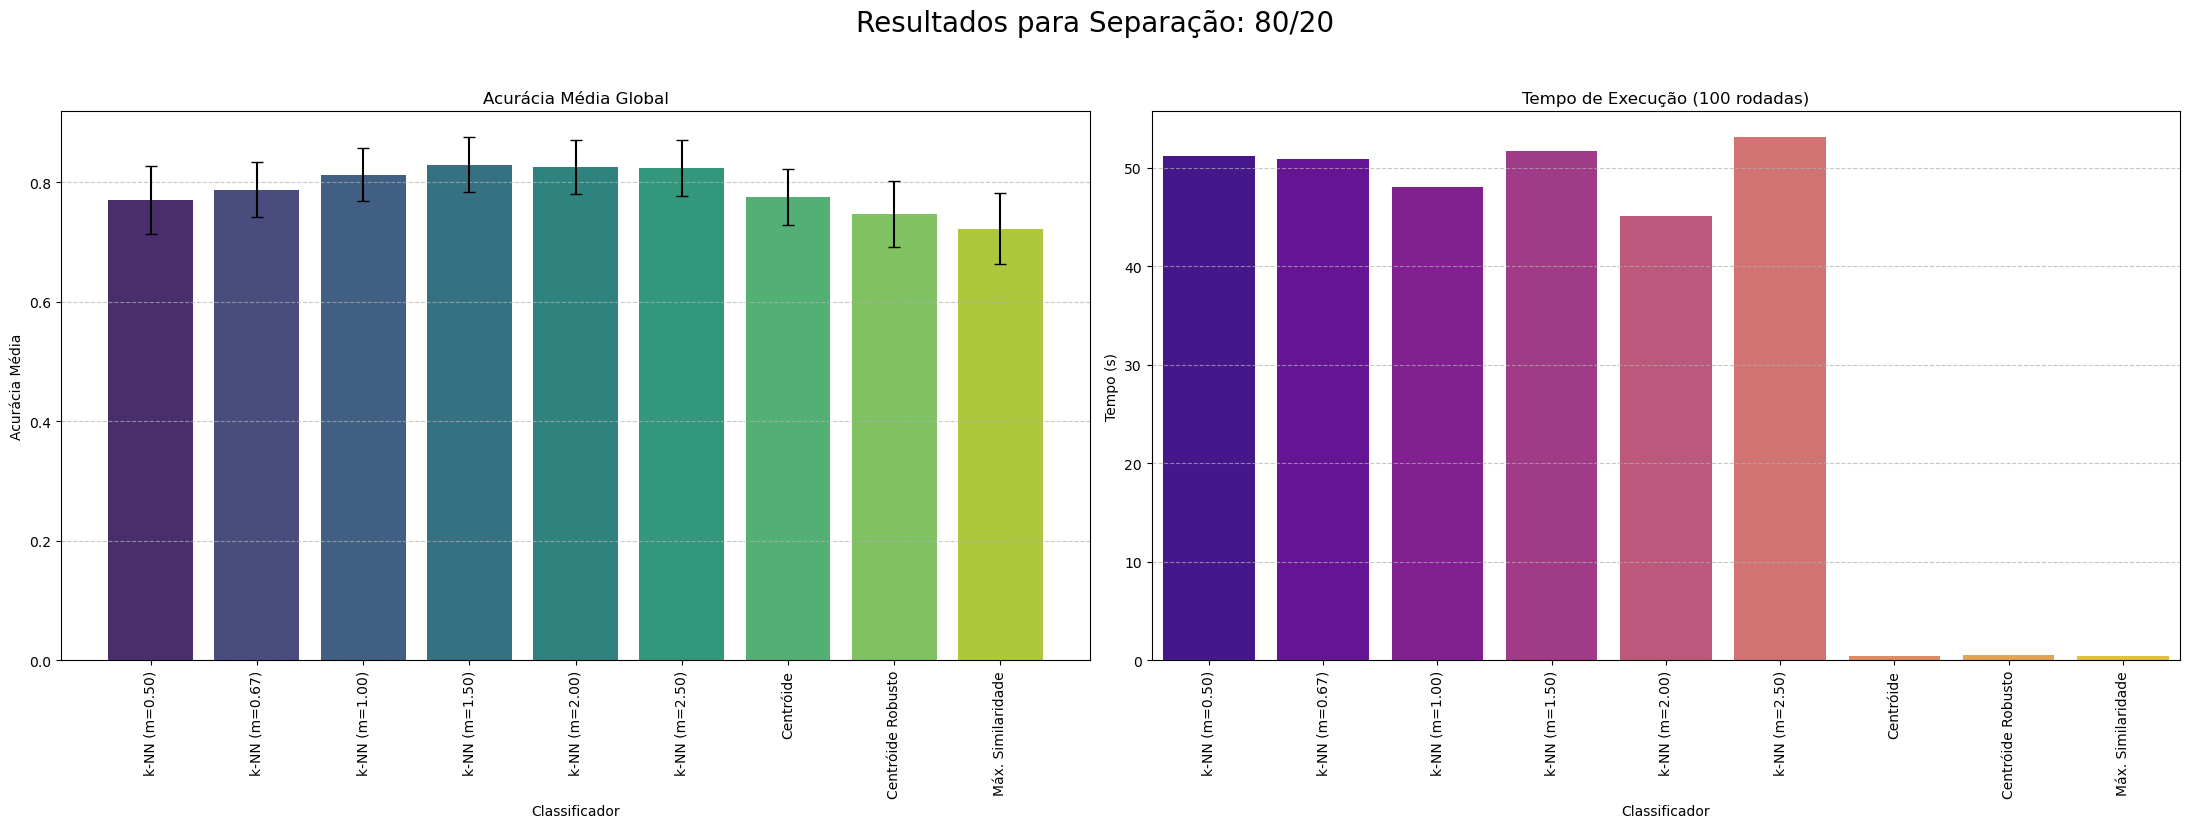

C:\Users\GREI-Luis-Felipe\AppData\Local\Temp\ipykernel_8708\3689277163.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
C:\Users\GREI-Luis-Felipe\AppData\Local\Temp\ipykernel_8708\3689277163.py:51: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(
C:\Users\GREI-Luis-Felipe\AppData\Local\Temp\ipykernel_8708\3689277163.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['rotulo_curto'] = pd.Categorical(df_subset['rotulo_curto'], categories=rotulos_x, ordered=True)
C:\Users\GREI-Luis-Felipe\AppData\Local\Temp\ipykernel_8

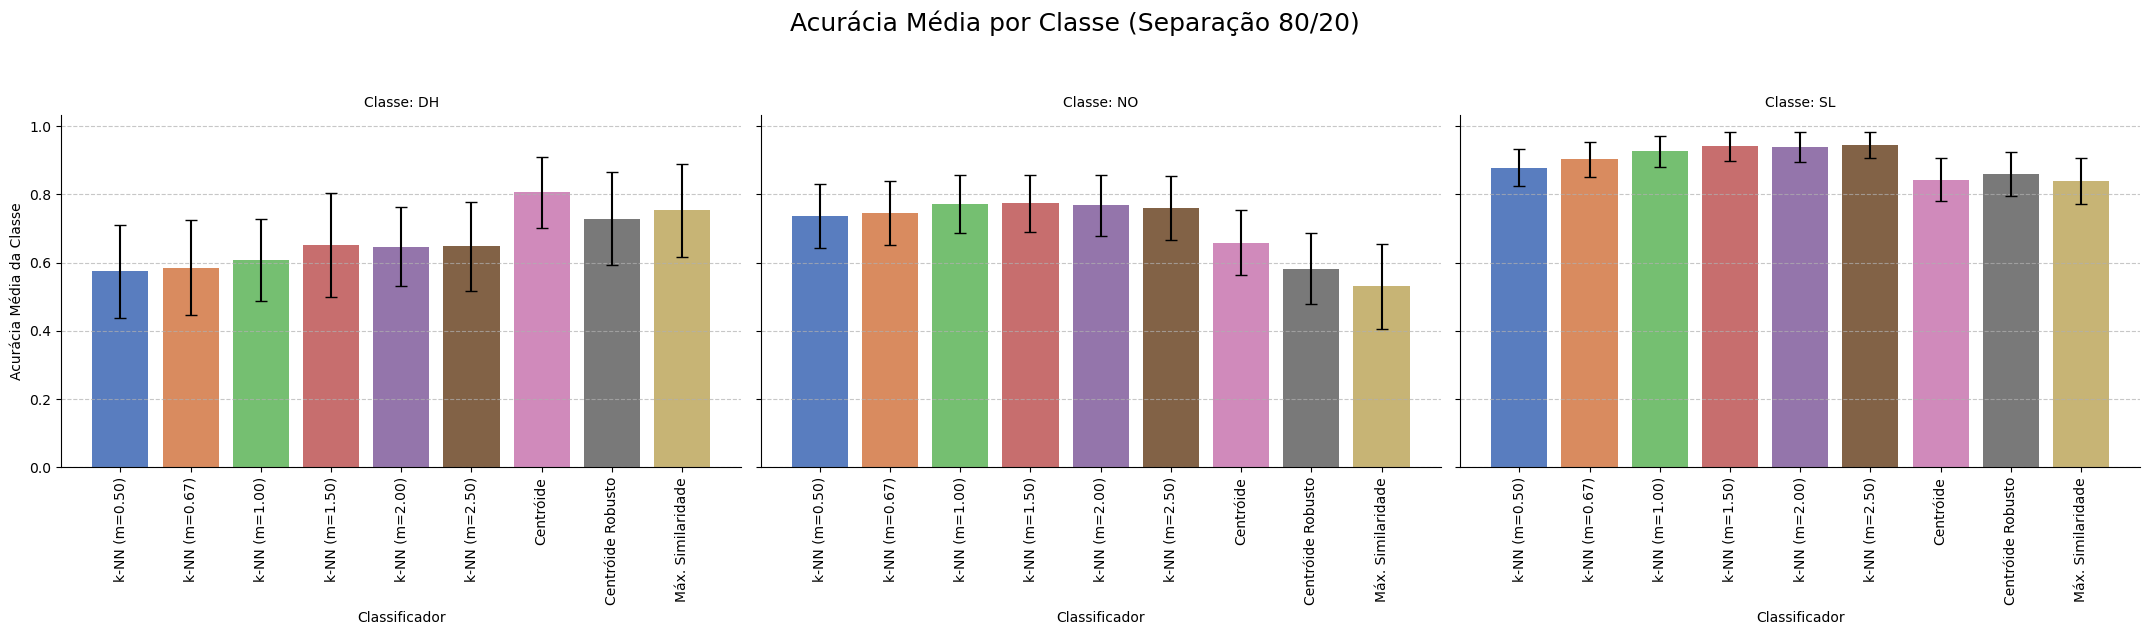

In [11]:
# 2. Geração dos Gráficos de Acurácia e Desempenho por Classe

if df_final_ordenado.empty or df_classes_ordenado.empty:
    print("DataFrames de resultados estão vazios. Execute as células dos classificadores e a célula 1 primeiro.")
else:
    # Itera sobre cada separação
    for s in ordem_separacao:
        
        print(f"--- Gerando gráficos para a separação {s} ---")
        
        # --- Filtra os dados apenas para esta separação ---
        df_g_s = df_final_ordenado[df_final_ordenado['separacao'] == s].copy()
        df_c_s = df_classes_ordenado[df_classes_ordenado['separacao'] == s].copy()
        
        # Pega a ordem dos rótulos para o eixo X
        rotulos_x = df_g_s['rotulo_curto'].unique()

        # ======================================================================
        # GRÁFICO 1: Acurácia Global e Tempo (lado a lado)
        # ======================================================================
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 8)) # 1 linha, 2 colunas
        fig.suptitle(f'Resultados para Separação: {s}', fontsize=20, y=1.03)

        # --- Plot 1.1: Acurácia Global ---
        sns.barplot(data=df_g_s, x='rotulo_curto', y='media', order=rotulos_x, ax=ax1, palette='viridis')
        # Adiciona barras de erro (desvio padrão)
        ax1.errorbar(x=rotulos_x, y=df_g_s['media'], yerr=df_g_s['desvio'], fmt='none', c='black', capsize=4)
        ax1.set_title('Acurácia Média Global')
        ax1.set_ylabel('Acurácia Média')
        ax1.set_xlabel('Classificador')
        ax1.set_xticklabels(rotulos_x, rotation=90)
        ax1.grid(axis='y', linestyle='--', alpha=0.7)

        # --- Plot 1.2: Tempo ---
        sns.barplot(data=df_g_s, x='rotulo_curto', y='tempo', order=rotulos_x, ax=ax2, palette='plasma')
        ax2.set_title('Tempo de Execução (100 rodadas)')
        ax2.set_ylabel('Tempo (s)')
        ax2.set_xlabel('Classificador')
        ax2.set_xticklabels(rotulos_x, rotation=90)
        ax2.grid(axis='y', linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.savefig(f'grafico_global_tempo_{s.replace("/", "-")}.png')
        plt.show()

        # ======================================================================
        # GRÁFICO 2: Acurácia por Classe (sub-plots)
        # ======================================================================
        
        # Usamos catplot para criar subplots (colunas) para cada classe
        g = sns.catplot(
            data=df_c_s, 
            x='rotulo_curto', 
            y='media_classe', 
            col='classe',         # Cria um subplot para cada classe
            col_order=C_ordenado, # Garante a ordem (DH, NO, SL)
            kind='bar', 
            ci=None,              # Desligamos a barra de erro padrão
            height=6,             # Altura de cada subplot
            aspect=1.2,           # Proporção (largura/altura)
            order=rotulos_x,      # Garante a mesma ordem de barras
            palette='muted'
        )
        
        g.fig.suptitle(f'Acurácia Média por Classe (Separação {s})', y=1.05, fontsize=18)

        # Adiciona as barras de erro (desvio padrão) manualmente
        for i, ax in enumerate(g.axes.flat):
            classe_nome = g.col_names[i] # Pega o nome da classe (ex: 'DH')
            
            # Filtra o DataFrame de classes para esta classe e separação
            df_subset = df_c_s[df_c_s['classe'] == classe_nome]
            
            # Garante que os dados do subset estejam na ordem correta
            df_subset['rotulo_curto'] = pd.Categorical(df_subset['rotulo_curto'], categories=rotulos_x, ordered=True)
            df_subset = df_subset.sort_values('rotulo_curto')
            
            # Plota a barra de erro
            ax.errorbar(
                x=df_subset['rotulo_curto'], 
                y=df_subset['media_classe'],
                yerr=df_subset['desvio_classe'], 
                fmt='none', 
                c='black', 
                capsize=4
            )
            
            ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
            ax.set_ylabel('Acurácia Média da Classe')
            ax.set_xlabel('Classificador')
            ax.grid(axis='y', linestyle='--', alpha=0.7)

        g.set_titles("Classe: {col_name}") # Título de cada subplot
        plt.tight_layout()
        plt.savefig(f'grafico_por_classe_{s.replace("/", "-")}.png')
        plt.show()

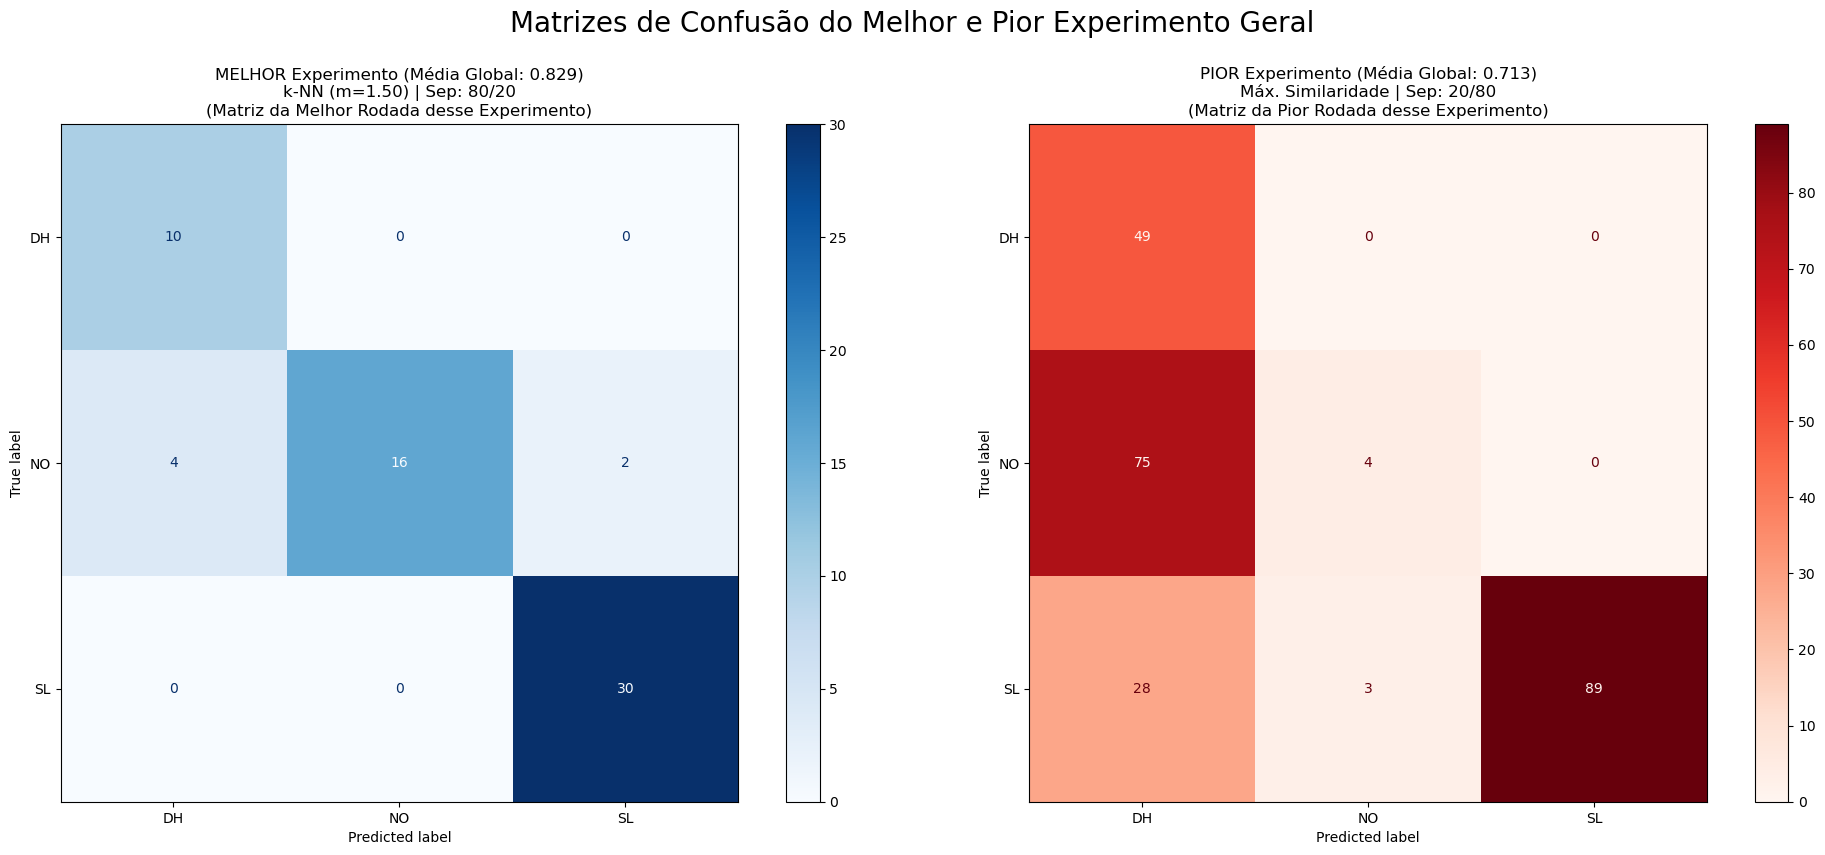

In [12]:
# 3. Plotagem da Melhor e Pior Matriz de Confusão (Geral)

if df_final_ordenado.empty:
    print("DataFrame 'df_final_ordenado' está vazio. Execute as células anteriores primeiro.")
else:
    try:
        # --- Encontra as linhas de MELHOR e PIOR experimento GERAL ---
        # .loc[df_final_ordenado['media'].idxmax()] pega a linha inteira (como uma Series)
        best_exp_row = df_final_ordenado.loc[df_final_ordenado['media'].idxmax()]
        worst_exp_row = df_final_ordenado.loc[df_final_ordenado['media'].idxmin()]

        # --- Criação dos Gráficos ---
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        fig.suptitle('Matrizes de Confusão do Melhor e Pior Experimento Geral', fontsize=20, y=1.03)

        # --- Plot 3.1: Matriz do MELHOR Experimento ---
        # Usamos a 'matriz_confusao_melhor' (da melhor rodada) do melhor experimento
        disp_melhor = ConfusionMatrixDisplay(
            confusion_matrix=best_exp_row['matriz_confusao_melhor'],
            display_labels=best_exp_row['classes_matriz']
        )
        disp_melhor.plot(ax=ax1, cmap='Blues', values_format='d') # 'd' = inteiro
        
        # Título descritivo
        titulo_melhor = (
            f"MELHOR Experimento (Média Global: {best_exp_row['media']:.3f})\n"
            f"{best_exp_row['rotulo_curto']} | Sep: {best_exp_row['separacao']}\n"
            f"(Matriz da Melhor Rodada desse Experimento)"
        )
        ax1.set_title(titulo_melhor, fontsize=12)

        # --- Plot 3.2: Matriz do PIOR Experimento ---
        # Usamos a 'matriz_confusao_pior' (da pior rodada) do pior experimento
        disp_pior = ConfusionMatrixDisplay(
            confusion_matrix=worst_exp_row['matriz_confusao_pior'],
            display_labels=worst_exp_row['classes_matriz']
        )
        disp_pior.plot(ax=ax2, cmap='Reds', values_format='d') # 'd' = inteiro
        
        # Título descritivo
        titulo_pior = (
            f"PIOR Experimento (Média Global: {worst_exp_row['media']:.3f})\n"
            f"{worst_exp_row['rotulo_curto']} | Sep: {worst_exp_row['separacao']}\n"
            f"(Matriz da Pior Rodada desse Experimento)"
        )
        ax2.set_title(titulo_pior, fontsize=12)

        plt.tight_layout()
        plt.savefig('grafico_melhor_pior_matriz_confusao.png')
        plt.show()

    except Exception as e:
        print(f"Erro ao plotar matrizes de confusão: {e}")
        print("Verifique se as matrizes foram salvas corretamente nos dicionários de resultados.")